In [1]:
import random
from collections import deque

import numpy as np
import gym

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(4, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 2),
        )
        
    def forward(self, x):
        x = self.layer(x)
        
        return x

In [4]:
model = Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [5]:
score = []
memory = deque(maxlen=2000)

In [6]:
env = gym.make("CartPole-v1")

In [7]:
for i in range(1000):
    state = env.reset()
    state = np.reshape(state, [1, 4])
    eps = 1 / (i / 50 + 10)
    
    for t in range(500):
        env.render()
        if np.random.rand() < eps:
            action = np.random.randint(0, 2)
        else:
            predict = model(torch.Tensor(state))
            action = np.argmax(predict.detach().numpy())
            
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 4])
        
        memory.append((state, action, reward, next_state, done))
        state = next_state
        
        if done or t == 499:
            print("Episode", i, "Score", t + 1)
            score.append(t + 1)
            break
    
    if i > 10:
        minibatch = random.sample(memory, 16)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            
            if not done:
                pred = model(torch.Tensor(next_state))[0]
                target = reward + 0.9 * np.amax(pred.detach().numpy())
            
            target_outputs = model(torch.Tensor(state))
            target_outputs[0][action] = target
            
            for epoch in range(1):
                model.train()
                
                output = model(torch.Tensor(state))
                loss = criterion(output, target_outputs)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                model.eval()
            
env.close()
print(score)

Episode 0 Score 8
Episode 1 Score 9
Episode 2 Score 10
Episode 3 Score 9
Episode 4 Score 9
Episode 5 Score 10
Episode 6 Score 10
Episode 7 Score 10
Episode 8 Score 11
Episode 9 Score 10
Episode 10 Score 13
Episode 11 Score 8
Episode 12 Score 11
Episode 13 Score 9
Episode 14 Score 14
Episode 15 Score 12
Episode 16 Score 10
Episode 17 Score 9
Episode 18 Score 10
Episode 19 Score 9
Episode 20 Score 9
Episode 21 Score 9
Episode 22 Score 9
Episode 23 Score 9
Episode 24 Score 8
Episode 25 Score 10
Episode 26 Score 10
Episode 27 Score 9
Episode 28 Score 8
Episode 29 Score 10
Episode 30 Score 8
Episode 31 Score 10
Episode 32 Score 10
Episode 33 Score 8
Episode 34 Score 11
Episode 35 Score 9
Episode 36 Score 9
Episode 37 Score 11
Episode 38 Score 10
Episode 39 Score 9
Episode 40 Score 10
Episode 41 Score 9
Episode 42 Score 10
Episode 43 Score 10
Episode 44 Score 11
Episode 45 Score 11
Episode 46 Score 10
Episode 47 Score 10
Episode 48 Score 8
Episode 49 Score 11
Episode 50 Score 13
Episode 51 S

In [8]:
import matplotlib.pyplot as plt

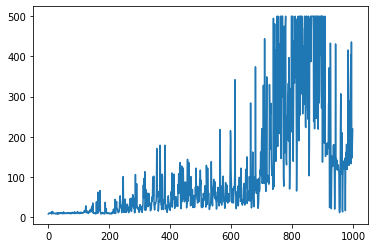

In [9]:
plt.plot(score)
plt.show()